# Mordred processing example for Negishi dataset

### Import libraries

In [2]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from mordred import Calculator, descriptors

paths = [
    '/home/ubuntu/reaction-gcnn/data/'
]

### Load dataset

In [3]:
df = None
my_path = None
for path in paths:
    try:
        df = pd.read_excel(path+'Negishi_binned_final.xlsx', 
                     sheet_name = 'binned_final', usecols = tuple([3,4,5,6]),
                     nrows = 6392, verbose = True)
        my_path = path
        break
    except FileNotFoundError:
        pass

if df is None:
    raise FileNotFoundError("None of the paths are valid")

df.columns = ['reactant_1', 'reactant_2', 'product', 'yield']

Reading sheet binned_final


In [4]:
# Remove null entries
df = df.dropna()

# Remove entries with failed RDKit parsing
df = df[df['reactant_1'].apply(Chem.MolFromSmiles).notna()]
df = df[df['reactant_2'].apply(Chem.MolFromSmiles).notna()]
df = df[df['product'].apply(Chem.MolFromSmiles).notna()]

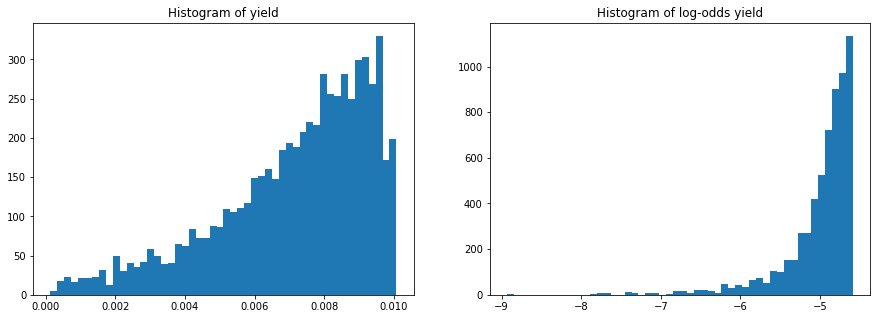

In [5]:
# Plot dataset yield distribution
y = df['yield']/100
y = (y * (len(y) - 1) + 0.5)/len(y)

fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].hist(y, 50);
axes[0].set_title('Histogram of yield');
axes[1].hist(np.log(y/(1-y)), bins = 50);
axes[1].set_title('Histogram of log-odds yield');

### Calculate Mordred vectors

In [6]:
# Initialize Mordred calculator
calc = Calculator(descriptors, ignore_3D=False)

In [7]:
# Make lists of all molecules in dataset by reaction component
reactancts_1 = [Chem.MolFromSmiles(smile) for smile in df['reactant_1']]
reactancts_2 = [Chem.MolFromSmiles(smile) for smile in df['reactant_2']]
products = [Chem.MolFromSmiles(smile) for smile in df['product']]

In [9]:
# Run Mordred calculator and create raw dataframes with the descriptor vectors
rdf_1 = calc.pandas(reactancts_1)

 32%|███▏      | 1985/6242 [06:39<44:33,  1.59it/s]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 6242/6242 [19:06<00:00, 10.05it/s]


In [10]:
rdf_2 = calc.pandas(reactancts_2)

 65%|██████▍   | 4047/6242 [07:31<16:06,  2.27it/s]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 6242/6242 [11:44<00:00,  8.86it/s]


In [11]:
pdf = calc.pandas(products)

 32%|███▏      | 1984/6242 [07:17<46:38,  1.52it/s]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 65%|██████▍   | 4056/6242 [13:57<23:02,  1.58it/s]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 70%|██████▉   | 4357/6242 [14:59<14:36,  2.15it/s]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 6242/6242 [21:04<00:00,  3.56it/s]


In [12]:
# There are some columns that give nonsensical values: see SpAbs_A
# This set will vary by dataset. In practice, these were first calculated
# with the Suzuki dataset and transferred to the remaining 
# datasets for consistency.
prodcols = set(pdf.describe().columns)
reactcols_1 = set(rdf_1.describe().columns)
reactcols_2 = set(rdf_2.describe().columns)
cols = (prodcols.intersection(reactcols_1).intersection(reactcols_2))
print(len(cols))

1105


In [ ]:
# Filter out columns that are 0-valued throughout
pdfred = pdf[pdf[cols].columns[np.array(pdf[cols].describe())[2, :] != 0.0]]
rdfred_1 = rdf_1[rdf_1[cols].columns[np.array(rdf_1[cols].describe())[2, :] != 0.0]]
rdfred_2 = rdf_2[rdf_2[cols].columns[np.array(rdf_2[cols].describe())[2, :] != 0.0]]

In [14]:
# Only keep columns that were calculated for all reaction components
colsred = (set(pdfred.columns).intersection(set(rdfred_2.columns)).intersection(set(rdfred_1.columns)))
new_cols = (set(cols).intersection(set(colsred)))
print(len(colsred), len(new_cols))

668 668


In [13]:
# Create new dataframes with reduced column set
pdfred = pdf[new_cols]
rdfred_1 = rdf_1[new_cols]
rdfred_2 = rdf_2[new_cols]

668


### Save datasets to be loaded with full column parsing

In [15]:
# Save the dataframes to csv to be loaded with full input parsing
# Will be used to create hybrid inputs by concatenating with tokenized SMILES
pdfred.to_csv(my_path+'negishi_products_mordred.csv', index = True)
rdfred_1.to_csv(my_path+'negishi_reactants_1_mordred.csv', index = True)
rdfred_2.to_csv(my_path+'negishi_reactants_2_mordred.csv', index = True)